# K Neighbors Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots

from sklearn.naive_bayes import GaussianNB

import sys
sys.path.append("../..")
from E4525_ML import plots
from E4525_ML import samples

## Preliminaries

### Random Seed

In [2]:
seed=23565
np.random.seed(seed)

## Generate Random Classification Data 

In [3]:

N = 80 # number of points  in training data

# sample data on an ellipse with axis at 45 degrees
X1,Y1=samples.ellipsoid(N//2,R0=2,R1=8,theta0=np.pi/4)
X1_test,Y1_test=samples.ellipsoid(N,R0=2,R1=8,theta0=np.pi/4)

# sample data on an ellipse aligned with axis
X2,Y2=samples.ellipsoid(N//2,R0=2,R1=8,theta0=0)
X2_test,Y2_test=samples.ellipsoid(N,R0=2,R1=8,theta0=0)


We have two classes located on two concentric, and slighly off center ellipses

(-10, 10)

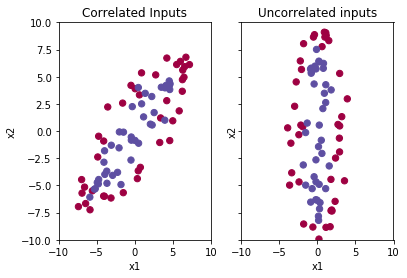

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
ax1.scatter(X1[:, 0], X1[:, 1], c=Y1, s=40, cmap=plt.cm.Spectral)
ax1.set_title("Correlated Inputs")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

ax2.scatter(X2[:, 0], X2[:, 1], c=Y2, s=40, cmap=plt.cm.Spectral)
ax2.set_title("Uncorrelated inputs")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])

#fig.savefig('ellipse.png')

In [5]:
def one_hot(y):
    N=len(y)
    Zy=np.zeros((N,2))
    Zy[np.arange(N),y]=1
    return Zy

In [6]:
one_hot(Y1).shape

(80, 2)

## Gaussian Naive Bayes Classifier

### Gaussian Distribution Parameter estimates

$$
    \hat{N}_k = \sum_i z_{i,k}
$$
$$
    \hat{\mu}_{d,k} = \frac{1}{\hat{N}_k} \sum_i x_{i,d} z_{i,k}
$$
$$
    \hat{\sigma}^2_{d,k} =  \frac{1}{\hat{N}_k} \sum_i \left(x_{i,d}-\hat{\mu}_{i,k}\right)^2 z_{i,k}
       = \frac{1}{\hat{N}_k} \sum_i x_{i,d}^2 z_{i,k} - \hat{\mu}_{d,k}^2
$$

In [7]:
# X_{i,d} indexed per sample (i), and dimension (d)
X=X2
Y=Y2
# Z_{i,k} indexed per sample (i), and class (k)
ZY=one_hot(Y)
N=len(Y)

In [8]:
# Total count per class
N_hat=ZY.sum(axis=0)
N_hat

array([40., 40.])

In [9]:
# mu_{d,k} mean per dimension and class
mu= np.dot(X.T,ZY)/N_hat
mu

array([[ 0.19418257, -0.0281746 ],
       [ 0.14301312,  0.05183893]])

In [10]:
# sigma_{d,k} variance per dimension and class 
sigma2=np.dot((X*X).T,ZY)/N_hat - mu*mu
sigma2

array([[ 5.49440999,  0.70348704],
       [38.08907232, 25.87572723]])

In [11]:
# pi_k empirical probability per class
pi=N_hat/N
pi

array([0.5, 0.5])

### Loss Function estimate

From the lecture notes, we see that the cross entropy loss for a Gaussian Naive Bayes model is given by
\begin{equation}
	L_{i,k}(x) =-\log p(y_i=k|x_i)= \frac{1}{2}\sum_{d}\left\{ \left( \frac{x_{i,d} - \hat{\mu}_{d,k}}{\hat{\sigma}_{d,k}}\right)^2 + \log \left( 2\pi \hat{\sigma}_{d,k}^2\right) \right\}- \log \hat{\pi}_k
\end{equation}

*(here we have an extra index $i$ relative to the lecture notes because we are computing the loss for many samples at the same time.)*

In [12]:
# compute cross entropy loss under gaussian assumptions
def L(X,mu,sigma2,pi):
    # delta_{i,d,k} = X_{i,d}-mu_k
    delta=X[:,:,np.newaxis]-mu[np.newaxis,:,:]
    # delta2_{i,k,d} = delta_{i,d,k}^2/sigma_{d,k}
    delta2=delta*delta/sigma2[np.newaxis,:,:]
    #delta2_{i,k,d} = delta_{i,d,k}^2/sigma_{d,k} + lg (2 pi_k*sigma_{d,k})
    delta2+=np.log(2*np.pi*sigma2) # don't forget this extra term.
    # l = 0.5\sum_d delta2_{i,d,k} - pi_k
    l=0.5*np.sum(delta2,axis=1)
    return l - np.log(pi)
    

In [13]:
# l_{i,k} cross entropy loss for sample i, class k
l=L(X2,mu,sigma2,pi)
l.shape

(80, 2)

In [14]:
# select class with lower loss (higher likelihood)
l.argmin(axis=1)

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

In [15]:
Y_pred=l.argmin(axis=1)
np.mean(Y_pred==Y)

0.85

### Gaussian Naive Bayes Classifier

We can collect the parameter estimation and the loss function calculation into a classifier class with `sklearn`'s API.

In [16]:
class GaussianNaiveBayes:
    def __init__(self):
        pass
    def fit(self,X,Y):
        # estimate gaussian distribution parameters, per class and dimension.
        Zy=one_hot(Y)
        N_hat=Zy.sum(axis=0)
        self.pi=N_hat/N
        self.mu= np.dot(X.T,ZY)/N_hat
        self.sigma2=np.dot((X*X).T,ZY)/N_hat - self.mu*self.mu
    def loss(self,X):
        return L(X,self.mu,self.sigma2,self.pi)
    def proba(self,X):
        l=self.loss(X)
        p=np.exp(-l)
        p=p/p.sum(axis=1)[:,np.newaxis]
        return p
    def predict(self,X):
        l=self.loss(X)
        return l.argmin(axis=1)
        

## SKLearn comparison

We can compare our model

In [17]:
model=GaussianNaiveBayes()
model.fit(X1,Y1)
train_acc=np.mean(model.predict(X1)==Y1)
test_acc=np.mean(model.predict(X1_test)==Y1_test)
print("train accuracy",train_acc)
print("test accuracy",test_acc)

train accuracy 0.675
test accuracy 0.68125


to [`sklearn`'s clasifier](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)

In [18]:
sk_model=GaussianNB()
sk_model.fit(X1,Y1)
train_acc=np.mean(sk_model.predict(X1)==Y1)
test_acc=np.mean(sk_model.predict(X1_test)==Y1_test)
print("train accuracy",train_acc)
print("test accuracy",test_acc)

train accuracy 0.675
test accuracy 0.68125


We can also compare parameters

In [19]:
print("mu",model.mu)
print("sk mu",sk_model.theta_.T)

mu [[ 0.39031107 -0.50589779]
 [ 0.20179397 -0.49673266]]
sk mu [[ 0.39031107 -0.50589779]
 [ 0.20179397 -0.49673266]]


In [20]:
print("sigma",model.sigma2)
print("sk sigma",sk_model.sigma_.T)

sigma [[23.31964445 10.79149142]
 [22.6307283  11.53211623]]
sk sigma [[23.31964447 10.79149144]
 [22.63072831 11.53211625]]


In [21]:
print("pi",model.pi)
print("sk pi",sk_model.class_prior_)

pi [0.5 0.5]
sk pi [0.5 0.5]


Probabilities

In [22]:
print("p",model.proba(X[:5]))
print("sk L",sk_model.predict_proba(X[:5]))

p [[0.42296273 0.57703727]
 [0.43179677 0.56820323]
 [0.41640303 0.58359697]
 [0.46525303 0.53474697]
 [0.63839193 0.36160807]]
sk L [[0.42296273 0.57703727]
 [0.43179677 0.56820323]
 [0.41640303 0.58359697]
 [0.46525303 0.53474697]
 [0.63839193 0.36160807]]


We also train a model on the second data sample

In [23]:
model2=GaussianNaiveBayes()
model2.fit(X2,Y2)
train_acc=np.mean(model2.predict(X2)==Y2)
test_acc=np.mean(model2.predict(X2_test)==Y2_test)
print("train accuracy",train_acc)
print("test accuracy",test_acc)

train accuracy 0.85
test accuracy 0.78125


Generalization performance is not as good as training set performance

### Decision Boundary

### Sample 1

Text(0.5,1,'Test Data Performance')

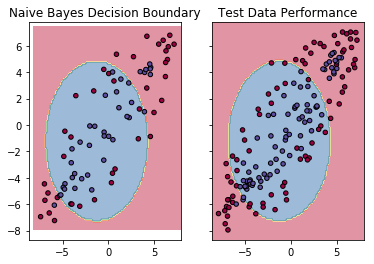

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
plots.decision_boundary_2d(model,X1,Y1,ax1)
ax1.set_title("Naive Bayes Decision Boundary")
plots.decision_boundary_2d(model,X1_test,Y1_test,ax2)
ax2.set_title("Test Data Performance")
#fig.savefig('overfitted.png')

Text(0,0.5,'x2')

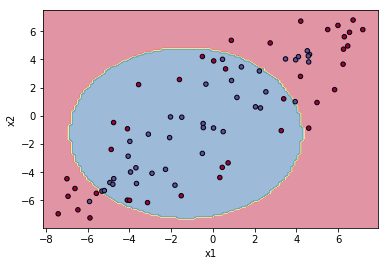

In [25]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(model,X1,Y1,ax1)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

### Sample2

Text(0.5,1,'Test Data Performance')

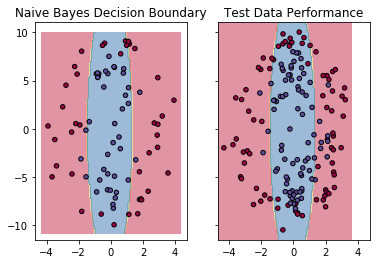

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True)
plots.decision_boundary_2d(model2,X2,Y2,ax1)
ax1.set_title("Naive Bayes Decision Boundary")
plots.decision_boundary_2d(model2,X2_test,Y2_test,ax2)
ax2.set_title("Test Data Performance")

Text(0,0.5,'x2')

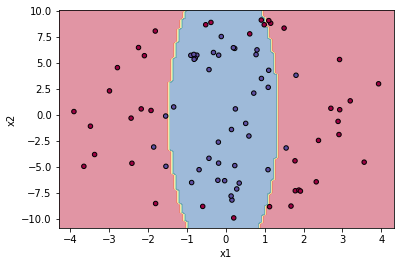

In [27]:
f, ax1 = plt.subplots(1, 1, sharey=True,sharex=True)
plots.decision_boundary_2d(model2,X2,Y2,ax1)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

### Plot distributional assumptions

In [28]:
true=Y==1
x=X2[true]
x.shape

(40, 2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  This is separate from the ipykernel package so we can avoid doing imports until


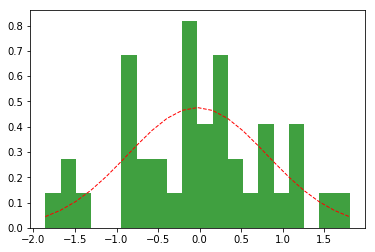

In [29]:
# the histogram of the data
n, bins, patches = plt.hist(x[:,0], 20, normed=1, facecolor='green', alpha=0.75)
y = mlab.normpdf( bins, mu[0,1], np.sqrt(sigma2[0,1]))
l = plt.plot(bins, y, 'r--', linewidth=1)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  This is separate from the ipykernel package so we can avoid doing imports until


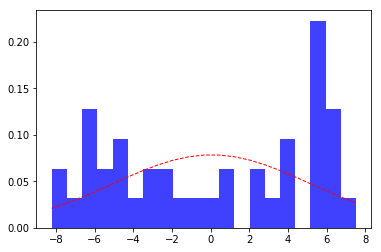

In [30]:
# the histogram of the data
n, bins, patches = plt.hist(x[:,1], 20, normed=1, facecolor='blue', alpha=0.75)
y = mlab.normpdf( bins, mu[1,1], np.sqrt(sigma2[1,1]))
l = plt.plot(bins, y, 'r--', linewidth=1)